In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, SVR
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV

In [ ]:
## Se importan los datos

In [2]:
data = pd.read_csv('bank-full.csv')

1. Title: Bank Marketing

Sources Created by: Paulo Cortez (Univ. Minho) and Sérgio Moro (ISCTE-IUL) @ 2012

Past Usage:

The full dataset was described and analyzed in:

S. Moro, R. Laureano and P. Cortez. Using Data Mining for Bank Direct Marketing: An Application of the CRISP-DM Methodology. In P. Novais et al. (Eds.), Proceedings of the European Simulation and Modelling Conference - ESM'2011, pp. 117-121, Guimarães, Portugal, October, 2011. EUROSIS.

Relevant Information:

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be (or not) subscribed.

There are two datasets: 1) bank-full.csv with all examples, ordered by date (from May 2008 to November 2010). 2) bank.csv with 10% of the examples (4521), randomly selected from bank-full.csv. The smallest dataset is provided to test more computationally demanding machine learning algorithms (e.g. SVM).

The classification goal is to predict if the client will subscribe a term deposit (variable y).

Number of Instances: 45211 for bank-full.csv (4521 for bank.csv)

Number of Attributes: 16 + output attribute.

Attribute information:

For more information, read [Moro et al., 2011].

Input variables:

bank client data:
1 - age (numeric) 2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student", "blue-collar","self-employed","retired","technician","services") 3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed) 4 - education (categorical: "unknown","secondary","primary","tertiary") 5 - default: has credit in default? (binary: "yes","no") 6 - balance: average yearly balance, in euros (numeric) 7 - housing: has housing loan? (binary: "yes","no") 8 - loan: has personal loan? (binary: "yes","no")

related with the last contact of the current campaign:
9 - contact: contact communication type (categorical: "unknown","telephone","cellular") 10 - day: last contact day of the month (numeric) 11 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec") 12 - duration: last contact duration, in seconds (numeric)

other attributes:
13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact) 14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted) 15 - previous: number of contacts performed before this campaign and for this client (numeric) 16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

Output variable (desired target): 17 - y - has the client subscribed a term deposit? (binary: "yes","no")

Missing Attribute Values: None

In [3]:
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
age          45211 non-null int64
job          45211 non-null object
marital      45211 non-null object
education    45211 non-null object
default      45211 non-null object
balance      45211 non-null int64
housing      45211 non-null object
loan         45211 non-null object
contact      45211 non-null object
day          45211 non-null int64
month        45211 non-null object
duration     45211 non-null int64
campaign     45211 non-null int64
pdays        45211 non-null int64
previous     45211 non-null int64
poutcome     45211 non-null object
y            45211 non-null object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [5]:
null_cols = data.isnull().sum()
null_cols[null_cols > 0]

Series([], dtype: int64)

In [6]:
data['y'].value_counts()

no     39922
yes     5289
Name: y, dtype: int64

In [7]:
data['loan'].value_counts()
data['poutcome'].value_counts()
data['month'].value_counts()

may    13766
jul     6895
aug     6247
jun     5341
nov     3970
apr     2932
feb     2649
jan     1403
oct      738
sep      579
mar      477
dec      214
Name: month, dtype: int64

In [8]:
data['job'].value_counts()

blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: job, dtype: int64

In [9]:
def meses_to_num(mes):
    '''
    devuelve el número de mes
    '''
    meses = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']
    num = meses.index(mes) + 1
    return num
    

In [10]:
data['month'] = data['month'].apply(meses_to_num)

In [11]:
data['month'].dtype

dtype('int64')

In [12]:
data['y'] = data['y'].apply(lambda x : 0 if x == 'no' else 1 )

In [13]:
data['y'].value_counts()

0    39922
1     5289
Name: y, dtype: int64

In [14]:
data_corr = data.corr()
data_corr

,age,balance,day,month,duration,campaign,pdays,previous,y
age,1.000000,0.097783,-0.009120,0.092903,-0.004648,0.004760,-0.023758,0.001288,0.025155
balance,0.097783,1.000000,0.004503,0.094605,0.021560,-0.014578,0.003435,0.016674,0.052838
day,-0.009120,0.004503,1.000000,0.101989,-0.030206,0.162490,-0.093044,-0.051710,-0.028348
month,0.092903,0.094605,0.101989,1.000000,-0.011866,0.054868,-0.108940,-0.035600,0.018717
duration,-0.004648,0.021560,-0.030206,-0.011866,1.000000,-0.084570,-0.001565,0.001203,0.394521
campaign,0.004760,-0.014578,0.162490,0.054868,-0.084570,1.000000,-0.088628,-0.032855,-0.073172
pdays,-0.023758,0.003435,-0.093044,-0.108940,-0.001565,-0.088628,1.000000,0.454820,0.103621
previous,0.001288,0.016674,-0.051710,-0.035600,0.001203,-0.032855,0.454820,1.000000,0.093236
y,0.025155,0.052838,-0.028348,0.018717,0.394521,-0.073172,0.103621,0.093236,1.000000


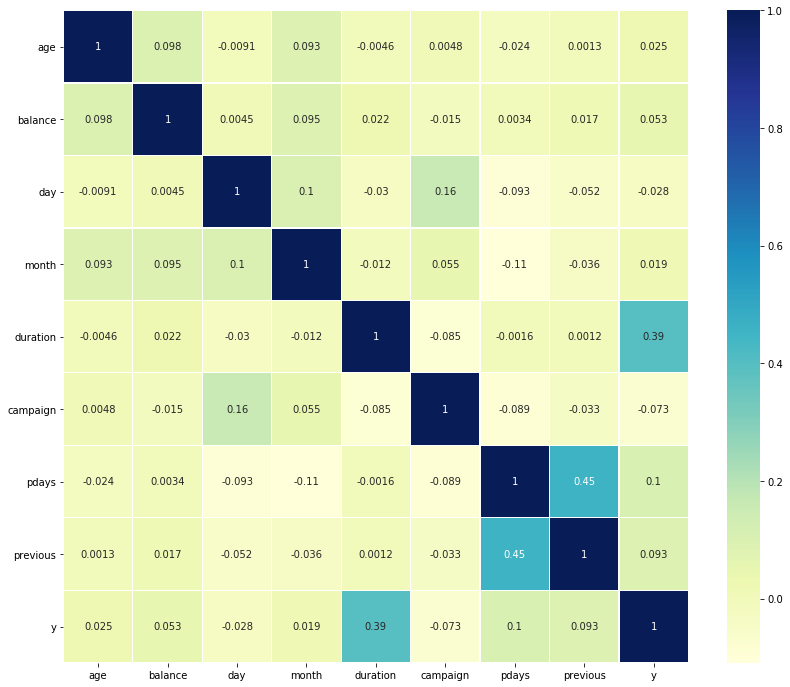

In [15]:
plt.figure(figsize = (14,12))
sns.heatmap(data_corr, linewidths =.2 ,cmap = 'YlGnBu', annot = True)
plt.yticks(rotation = 0);

In [17]:
data_dummy = pd.get_dummies(data, drop_first = True)

In [18]:
data_dummy.head()

,age,balance,day,month,duration,campaign,pdays,previous,y,job_blue-collar,...,education_tertiary,education_unknown,default_yes,housing_yes,loan_yes,contact_telephone,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,5,5,261,1,-1,0,0,0,...,1,0,0,1,0,0,1,0,0,1
1,44,29,5,5,151,1,-1,0,0,0,...,0,0,0,1,0,0,1,0,0,1
2,33,2,5,5,76,1,-1,0,0,0,...,0,0,0,1,1,0,1,0,0,1
3,47,1506,5,5,92,1,-1,0,0,1,...,0,1,0,1,0,0,1,0,0,1
4,33,1,5,5,198,1,-1,0,0,0,...,0,1,0,0,0,0,1,0,0,1


In [19]:
null_cols = data.isnull().sum()
null_cols[null_cols > 0]

Series([], dtype: int64)

In [20]:
temp = data_dummy.sample(n = 300)
temp['y'].value_counts()

0    257
1     43
Name: y, dtype: int64

In [21]:
X = temp.drop(axis=1, labels=['y'])
y = temp['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(240, 32) (60, 32) (240,) (60,)


C=1.0, kernel=’rbf’, degree=3, gamma=’auto_deprecated’, coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape=’ovr’, random_state=None)

In [22]:
parameters = {'kernel':('poly', 'rbf', 'sigmoid'), 
              'C':[1, 10]}

svc = SVC(gamma="scale")
clf = GridSearchCV(svc, parameters, cv = 2)
clf.fit(X_train, y_train)

GridSearchCV(cv=2, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel': ('poly', 'rbf', 'sigmoid'), 'C': [1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [23]:
sorted(clf.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'mean_train_score',
 'param_C',
 'param_kernel',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split0_train_score',
 'split1_test_score',
 'split1_train_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score',
 'std_train_score']

In [42]:
d = pd.DataFrame(clf.cv_results_)
d

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,mean_train_score,std_train_score
0,0.004973,0.002783,0.000926,0.000020,1,poly,"{'C': 1, 'kernel': 'poly'}",0.850000,0.850000,0.850000,0.000000,1,0.850000,0.850000,0.850000,0.000000
1,0.001776,0.000064,0.000958,0.000103,1,rbf,"{'C': 1, 'kernel': 'rbf'}",0.850000,0.850000,0.850000,0.000000,1,0.850000,0.850000,0.850000,0.000000
2,0.002322,0.000460,0.001330,0.000403,1,sigmoid,"{'C': 1, 'kernel': 'sigmoid'}",0.741667,0.850000,0.795833,0.054167,5,0.791667,0.850000,0.820833,0.029167
3,0.014743,0.012916,0.000835,0.000055,10,poly,"{'C': 10, 'kernel': 'poly'}",0.833333,0.850000,0.841667,0.008333,4,0.858333,0.850000,0.854167,0.004167
4,0.001734,0.000085,0.000864,0.000007,10,rbf,"{'C': 10, 'kernel': 'rbf'}",0.850000,0.841667,0.845833,0.004167,3,0.858333,0.858333,0.858333,0.000000
5,0.001593,0.000007,0.000880,0.000005,10,sigmoid,"{'C': 10, 'kernel': 'sigmoid'}",0.691667,0.791667,0.741667,0.050000,6,0.750000,0.825000,0.787500,0.037500


In [48]:
r = d[['mean_train_score']].idxmax()
d[['param_C', 'param_kernel', 'mean_train_score', 'mean_test_score']].loc[r]

,param_C,param_kernel,mean_train_score,mean_test_score
4,10,rbf,0.858333,0.845833


In [49]:
r = d[['mean_test_score']].idxmax()
d[['param_C', 'param_kernel', 'mean_train_score', 'mean_test_score']].loc[r]

,param_C,param_kernel,mean_train_score,mean_test_score
0,1,poly,0.85,0.85


In [45]:
parameters = {'kernel':('poly', 'rbf', 'sigmoid'), 
              'C':[1, 10]}

svc = SVC(gamma="scale")
clf2 = GridSearchCV(svc, parameters, cv = 5)
clf2.fit(X_train, y_train)

/home/sergio/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'kernel': ('poly', 'rbf', 'sigmoid'), 'C': [1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [46]:
d2 = pd.DataFrame(clf2.cv_results_)
d2

/home/sergio/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/sergio/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/sergio/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:125: FutureWarning: You are accessing a training score ('split2_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/sergio/anaconda3/lib/pyth

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.017326,0.011899,0.000846,0.000098,1,poly,"{'C': 1, 'kernel': 'poly'}",0.836735,0.854167,0.854167,...,0.850000,0.006824,1,0.853403,0.848958,0.848958,0.848958,0.849741,0.850004,0.001726
1,0.002108,0.000061,0.000823,0.000012,1,rbf,"{'C': 1, 'kernel': 'rbf'}",0.836735,0.854167,0.854167,...,0.850000,0.006824,1,0.853403,0.848958,0.848958,0.848958,0.849741,0.850004,0.001726
2,0.002085,0.000072,0.000827,0.000022,1,sigmoid,"{'C': 1, 'kernel': 'sigmoid'}",0.653061,0.729167,0.791667,...,0.766667,0.069687,5,0.753927,0.765625,0.760417,0.739583,0.849741,0.773859,0.038932
3,0.059805,0.017652,0.000816,0.000049,10,poly,"{'C': 10, 'kernel': 'poly'}",0.836735,0.854167,0.854167,...,0.850000,0.006824,1,0.853403,0.848958,0.848958,0.848958,0.849741,0.850004,0.001726
4,0.002228,0.000150,0.000771,0.000026,10,rbf,"{'C': 10, 'kernel': 'rbf'}",0.836735,0.854167,0.854167,...,0.850000,0.006824,1,0.853403,0.848958,0.848958,0.848958,0.849741,0.850004,0.001726
5,0.001969,0.000037,0.000790,0.000026,10,sigmoid,"{'C': 10, 'kernel': 'sigmoid'}",0.673469,0.666667,0.770833,...,0.725000,0.050321,6,0.738220,0.739583,0.729167,0.723958,0.766839,0.739554,0.014815


In [47]:
r = d2[['mean_train_score']].idxmax()
d2[['param_C', 'param_kernel', 'mean_train_score', 'mean_test_score']].loc[r]

,param_C,param_kernel,mean_train_score,mean_test_score
0,1,poly,0.850004,0.85


In [41]:
r = d2[['mean_test_score']].idxmax()
d2[['param_C', 'param_kernel', 'mean_train_score', 'mean_test_score']].loc[r]

,param_C,param_kernel,mean_train_score,mean_test_score
0,1,poly,0.850004,0.85


In [59]:
def modelos_svc():
    kernel = ['linear', 'poly', 'rbf', 'sigmoid']
    C = []

In [32]:
# Models

#parametros para svc

kernel = ['linear', 'poly', 'rbf', 'sigmoid']
C = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0]
gamma = [1, 2, 3, 4, 5, 6, 7, 8, 9]

cls_svc = SVC(kernel = 'rbf', gamma = 'auto', C = 1)


# Strategies
classifiers = [
    {'name':'SVM-v1 1v1', 'cls': OneVsOneClassifier(cls_svc) }
]

# Train Phase
for cls in classifiers:
    classifier = cls['cls']
    clsName = cls['name']
    classifier.fit(X_train, y_train) #entrenando
    score = classifier.score(X_test, y_test)
    print('{}\t\t{}'.format(score,clsName))

0.9725		SVM-v1 1v1


para evaluar no se necesita entrenar el modelo, utilizar el score

In [ ]:

columnas_filas = ['Bueno', 'Malo']
def dibuja_matriz(matrix, title, columnas):
    '''
    Para dibujar la matriz de confusión
    
    '''
    df = pd.DataFrame(matrix, 
                         index = [i for i in columnas],
                         columns = [i for i in columnas])

    plt.figure(figsize = (10,8))
    sns.heatmap(df ,linewidths = .1, cmap = 'YlGnBu', fmt = '.1f', annot = True)
    plt.title(title)
    plt.yticks(rotation = 0);